<a href="https://colab.research.google.com/github/joyalkosti/makemore/blob/master/Language_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [62]:
words = open('/content/names.txt').read().splitlines()
words[:20]


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett']

In [3]:
len(words)

32033

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# **Build the Datset for Compiling**

In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?
x, y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    x.append(context)
    y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
x = torch.tensor(x)
y = torch.tensor(y)

In [6]:
x.shape

torch.Size([228146, 3])

In [7]:
x

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [8]:
y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

# **Implementing the Embedding Lookup Table **

In [9]:
C = torch.randn((27, 2))


In [10]:
#Embedding of all the 32 values of indexex(In pytorch its easy you can just write it like this and it will automatically give embedding)
emb=C[x]
emb

tensor([[[-1.1422,  1.1820],
         [-1.1422,  1.1820],
         [-1.1422,  1.1820]],

        [[-1.1422,  1.1820],
         [-1.1422,  1.1820],
         [ 0.0517,  0.4132]],

        [[-1.1422,  1.1820],
         [ 0.0517,  0.4132],
         [ 0.7339,  1.4388]],

        ...,

        [[ 0.8912,  0.2503],
         [ 0.8912,  0.2503],
         [-0.0432,  0.7726]],

        [[ 0.8912,  0.2503],
         [-0.0432,  0.7726],
         [ 0.8912,  0.2503]],

        [[-0.0432,  0.7726],
         [ 0.8912,  0.2503],
         [-0.4343,  1.6662]]])

In [11]:
#Embedding with Original(13,3) and embedding 2 dimensional vector 
emb.shape

torch.Size([228146, 3, 2])

# **Constructing a Hidden layer**

In [12]:
W1 = torch.randn((6, 100)) #here we take 6(it's a multiple of 3*2 from original array and 100 Neurons)
b1 = torch.randn(100) #bias Weights


In [84]:
#Normally we would just take the Embedding(emb) and multiply with weights(W1) and add bias(B1)
emb @ W1 +b1 #But the problem is these embedding are all stack up in dimension of input Tensor (32,3,2) 
#can't multiply (6,100) so we need to concatent


RuntimeError: ignored

In [13]:
#There is a Function in pytorch Cat for concatenate
torch.cat([emb[: ,0, :], emb[: ,1, :], emb[: ,2, :]],1) 

tensor([[-1.1422,  1.1820, -1.1422,  1.1820, -1.1422,  1.1820],
        [-1.1422,  1.1820, -1.1422,  1.1820,  0.0517,  0.4132],
        [-1.1422,  1.1820,  0.0517,  0.4132,  0.7339,  1.4388],
        ...,
        [ 0.8912,  0.2503,  0.8912,  0.2503, -0.0432,  0.7726],
        [ 0.8912,  0.2503, -0.0432,  0.7726,  0.8912,  0.2503],
        [-0.0432,  0.7726,  0.8912,  0.2503, -0.4343,  1.6662]])

In [14]:
torch.cat([emb[: ,0, :], emb[: ,1, :], emb[: ,2, :]],1).shape #aswe can see this is what we want
#but this is not work on a generalise way (here there are 3 block size like 3 words but what if we want to take 4 or 5 words)

torch.Size([228146, 6])

In [15]:
#there is a fun in pytorch(Unbind)
torch.cat(torch.unbind(emb,1),1)

tensor([[-1.1422,  1.1820, -1.1422,  1.1820, -1.1422,  1.1820],
        [-1.1422,  1.1820, -1.1422,  1.1820,  0.0517,  0.4132],
        [-1.1422,  1.1820,  0.0517,  0.4132,  0.7339,  1.4388],
        ...,
        [ 0.8912,  0.2503,  0.8912,  0.2503, -0.0432,  0.7726],
        [ 0.8912,  0.2503, -0.0432,  0.7726,  0.8912,  0.2503],
        [-0.0432,  0.7726,  0.8912,  0.2503, -0.4343,  1.6662]])

In [16]:
torch.cat(torch.unbind(emb,1),1).shape
#as it's same what we want

torch.Size([228146, 6])

In [17]:
emb.view(228146,6) #as this is also one of fun that can generate directly the views that we want

tensor([[-1.1422,  1.1820, -1.1422,  1.1820, -1.1422,  1.1820],
        [-1.1422,  1.1820, -1.1422,  1.1820,  0.0517,  0.4132],
        [-1.1422,  1.1820,  0.0517,  0.4132,  0.7339,  1.4388],
        ...,
        [ 0.8912,  0.2503,  0.8912,  0.2503, -0.0432,  0.7726],
        [ 0.8912,  0.2503, -0.0432,  0.7726,  0.8912,  0.2503],
        [-0.0432,  0.7726,  0.8912,  0.2503, -0.4343,  1.6662]])

In [18]:
emb.view(228146,6)==torch.cat(torch.unbind(emb,1),1)
#As you can see it's all same

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        ...,
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True]])

In [19]:
h =emb.view(228146, 6) @ W1 + b1
h

tensor([[-2.1078, -1.0824,  5.5589,  ..., -3.3473, -2.2802,  0.3305],
        [-2.0643, -0.5110,  3.1835,  ...,  0.3122, -0.8597,  2.5237],
        [-0.8267, -0.4149, -0.8589,  ..., -1.5809,  3.9724, -0.8786],
        ...,
        [-1.4303,  1.2107, -0.2794,  ..., -1.9944,  1.1385, -3.2044],
        [-2.1515, -0.0352,  0.5794,  ...,  1.2672,  1.0450,  0.3677],
        [-0.8863,  0.3675, -0.0678,  ..., -4.5167,  2.3884, -4.2673]])

In [20]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h
#tanh because the number will be between -1 to 1

tensor([[-0.9709, -0.7941,  1.0000,  ..., -0.9975, -0.9793,  0.3190],
        [-0.9683, -0.4707,  0.9966,  ...,  0.3025, -0.6961,  0.9872],
        [-0.6787, -0.3926, -0.6957,  ..., -0.9187,  0.9993, -0.7057],
        ...,
        [-0.8917,  0.8369, -0.2724,  ..., -0.9636,  0.8139, -0.9967],
        [-0.9733, -0.0352,  0.5223,  ...,  0.8530,  0.7798,  0.3520],
        [-0.7096,  0.3518, -0.0677,  ..., -0.9998,  0.9833, -0.9996]])

In [21]:
h.shape

torch.Size([228146, 100])

In [22]:
b1.shape 
# as we can it's have 100 neurons so now it will add like
#32 100
1#(create fake), 100 

1

# **Now Create the Final(Output layer)**

In [23]:
W2 = torch.randn((100, 27))# 100 Neurons and 27  New Characters 
b2 = torch.randn(27) 

In [24]:
logits = h @ W2 + b2 #Logits are output of Neural Network
logits

tensor([[ -3.0623,   4.0607,   5.8062,  ...,   8.6667,  10.0632,  -8.6977],
        [  1.1618,   5.0217,  13.3810,  ...,   5.8972,   5.8010,  -5.4413],
        [ -4.3378,  13.4759,  -8.2860,  ...,  -1.7156,  12.6360,  -4.5549],
        ...,
        [  1.1232,   9.1224, -20.2438,  ...,  -2.3360,   4.7207,  -6.3676],
        [  9.5877,   1.9863,  -9.7029,  ...,  -0.2919,   0.4160,  -8.0172],
        [ -4.2795,  10.6533, -17.7273,  ...,   1.1356,  11.5635,  -1.0045]])

In [25]:
logits.shape

torch.Size([228146, 27])

# **Implementing negative Likely_hood**

In [26]:
#Now we take this logits and make a fake account and we want to Normalize in to Probability
Counts =logits.exp()

In [27]:
#Now Probability
prob = Counts / Counts.sum(1, keepdims=True)


In [28]:
prob.shape


torch.Size([228146, 27])

In [29]:
prob

tensor([[4.7707e-09, 5.9159e-06, 3.3894e-05,  ..., 5.9213e-04, 2.3928e-03,
         1.7027e-11],
        [3.7589e-08, 1.7840e-06, 7.6177e-03,  ..., 4.2821e-06, 3.8891e-06,
         5.0979e-11],
        [1.2587e-08, 6.8601e-01, 2.4280e-10,  ..., 1.7328e-07, 2.9618e-01,
         1.0131e-08],
        ...,
        [4.8849e-13, 1.4551e-09, 2.5661e-22,  ..., 1.5365e-14, 1.7833e-11,
         2.7268e-16],
        [8.2638e-05, 4.1299e-08, 3.4625e-13,  ..., 4.2317e-09, 8.5899e-09,
         1.8684e-12],
        [3.9612e-09, 1.2107e-02, 5.7215e-15,  ..., 8.9036e-07, 3.0085e-02,
         1.0474e-07]])

In [30]:
prob[0].sum() #As we can see every row of prob sums to 1(It,s Normalise)

tensor(1.0000)

In [32]:
loss = -prob[torch.arange(228146), y].log().mean()
loss 
#The final Predection of Y last character

tensor(15.0705)

# **Summary for Whole thing in small and Understanbdle**

In [33]:
x.shape, y.shape # dataset


(torch.Size([228146, 3]), torch.Size([228146]))

In [34]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters) # number of parameters in total


3481

In [36]:
emb = C[x] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
counts=logits.exp()
prob = Counts / Counts.sum(1, keepdims=True)
loss = -prob[torch.arange(228146), y].log().mean()
loss 


tensor(15.0705)

In [37]:
emb = C[x] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2 # (32, 27)
# counts=logits.exp()
# prob = Counts / Counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), y].log().mean()
# loss 
F.cross_entropy(logits,y) #We can also use Cross_Entropy 
loss

tensor(15.0705)

# **Implementing the Training Loop , Overfitting one batch**

In [38]:
for p in parameters:
  p.requires_grad = True


In [39]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [40]:
for _ in range(10):
  # forward pass
    emb = C[x] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y)
    print(loss.item())
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    # lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
      p.data += -0.1 * p.grad

19.505226135253906
17.08449363708496
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.051856994628906


# **Training the Full Dataset, MiniBatch**

In [41]:
for _ in range(100):
   # minibatch construct
    ix = torch.randint(0, x.shape[0], (32,))
  # forward pass
    emb = C[x[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    # lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
      p.data += -0.1 * p.grad

10.402192115783691
11.291410446166992
10.202068328857422
10.998786926269531
9.744996070861816
9.362805366516113
11.226117134094238
7.696069717407227
9.009435653686523
9.20141887664795
9.125584602355957
9.019814491271973
7.08469820022583
8.397106170654297
8.297504425048828
8.225672721862793
7.604303359985352
7.681474685668945
7.909390449523926
7.212578773498535
5.081681251525879
5.504915237426758
8.038368225097656
6.426581859588623
5.064785957336426
7.6576642990112305
5.741558074951172
6.834810733795166
5.539593696594238
5.668354034423828
5.534721851348877
5.241880893707275
5.317656993865967
6.034210205078125
5.404567718505859
4.5829620361328125
5.080471515655518
5.129422187805176
5.103428840637207
6.600259304046631
4.65148401260376
5.443518161773682
5.768989086151123
5.388398170471191
5.215490818023682
6.2704691886901855
4.171775817871094
5.975149631500244
4.561678886413574
4.543544292449951
4.897446632385254
4.973925590515137
4.714047908782959
6.219781398773193
4.7671051025390625
4.61

In [42]:
#Evaluate the loss
emb = C[x[ix]] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, y[ix])
loss

tensor(3.0660, grad_fn=<NllLossBackward0>)

# **Finding a good Initial Learning rate**

In [43]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [44]:
lri=[]
lossi=[]
for i in range(1000):
   # minibatch construct
    ix = torch.randint(0, x.shape[0], (32,))
  # forward pass
    emb = C[x[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    # lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
      p.data += -lr * p.grad

    #track stat
    lri.append(lr)
    lossi.append(loss.item())


3.0143158435821533
3.2295899391174316
2.9272122383117676
3.7029573917388916
3.5515215396881104
3.1591951847076416
3.6827197074890137
2.97457218170166
4.02423620223999
3.644627571105957
3.3759262561798096
3.088881731033325
3.348958969116211
3.974942922592163
3.4417619705200195
3.7613794803619385
3.5772361755371094
3.873506546020508
3.755626678466797
3.2751574516296387
3.857928514480591
3.246492862701416
3.249133586883545
3.142470121383667
3.5367493629455566
4.088107109069824
3.9072465896606445
3.9414453506469727
3.239542007446289
3.565978527069092
3.63662052154541
4.133208751678467
3.638090133666992
3.0509774684906006
2.7714154720306396
2.7341926097869873
3.7726731300354004
3.7057149410247803
3.5309879779815674
2.691497325897217
3.725513219833374
3.3793017864227295
4.467315196990967
3.5328238010406494
3.2396469116210938
3.8833463191986084
2.937265634536743
3.680391788482666
4.104469299316406
3.3978724479675293
3.4946224689483643
4.368276119232178
3.3899567127227783
4.175501346588135
3.8

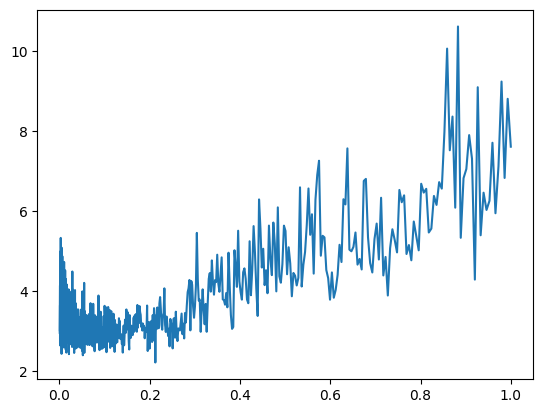

In [45]:
plt.plot(lri, lossi)


# **Split the dataset into 3 Train/Test/Valid**

In [46]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
len(words)

32033

In [48]:
n1, n2

(25626, 28829)

In [49]:
n2-n1

3203

In [50]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

# **Increase the size of Neural Network **

In [51]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [52]:
sum(p.nelement() for p in parameters) # number of parameters in total


11897

In [53]:
for p in parameters:
  p.requires_grad = True

In [54]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [55]:
lri = []
lossi = []
stepi = []

In [56]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

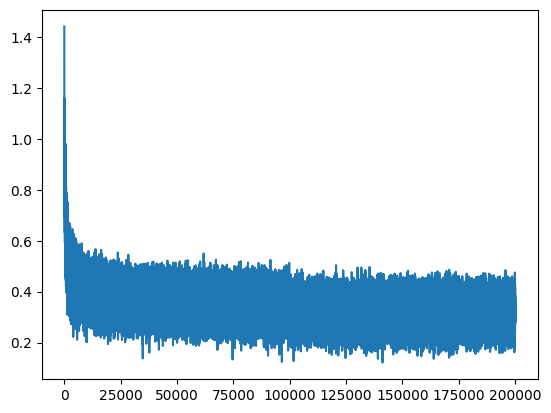

In [57]:
plt.plot(stepi, lossi)


In [58]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1121, grad_fn=<NllLossBackward0>)

In [59]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1547, grad_fn=<NllLossBackward0>)

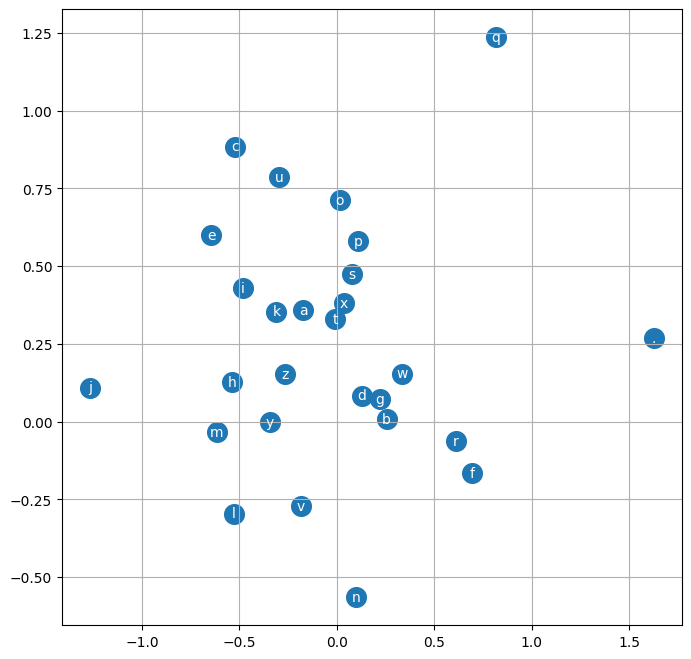

In [60]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# **Sample of Model**

In [61]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nihahal.
rethrelendraege.
zeredor.
illeyloren.
eden.
van.
naraelyzimontel.
noshibergiairiel.
kindreelle.
jose.
cayu.
zayven.
jamell.
eli.
kaysh.
ston.
azhia.
